In [1]:
import pandas as pd, seaborn as sns, numpy as np, datetime, logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s",
    handlers=[ logging.FileHandler("../logs/fraud_notebook.log"), logging.StreamHandler()])
input_train = pd.read_csv('../data/fraud/03_primary/x_train_transformed.csv').fillna(0)
output_train = pd.read_csv('../data/fraud/03_primary/y_train_transformed.csv').fillna(0)
input_test = pd.read_csv('../data/fraud/03_primary/x_test_transformed.csv')

data = pd.concat([input_train, output_train['fraud_flag']], axis=1)
target = pd.get_dummies(data['fraud_flag'])
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=0, shuffle=True, stratify=target)
logging.info(f'input_train={len(input_train.index)},output_train={len(output_train.index)},data={len(data.index)},target={len(target.index)},x_train={len(x_train.index)},'+\
      f'x_test={len(x_test.index)},y_train={len(y_train.index)},y_test={len(y_test.index)}')
x_train = x_train.drop(['fraud_flag'], axis=1)
x_test = x_test.drop(['fraud_flag'], axis=1)
y_test['ID'] = x_test['ID']
y_test['fraud_flag'] = y_test[1.0]

FileNotFoundError: [Errno 2] No such file or directory: '../data/fraud/03_primary/x_train_transformed.csv'

In [ ]:
from tensorflow import keras
from numpy.random import seed
from tensorflow.random import set_seed
seed(1)
set_seed(2)

In [ ]:
import seaborn as sns, keras
import matplotlib.pyplot as plt
def plot_history(history, metrics):
    """
    Plot the training history

    Args:
        metrics(str, list): Metric or a list of metrics to plot
    """
    history_df = pd.DataFrame.from_dict(history.history)
    sns.lineplot(data=history_df[metrics])
    plt.xlabel("epochs")
    plt.ylabel("RMSE")

In [ ]:
def score(y_true, y_pred_proba):
    import numpy as np
    from sklearn.metrics import average_precision_score
    ''' 
    Return the area under the Precision-Recall curve.  
    Args:
        - y_true (pd.DataFrame): Dataframe with a unique identifier for each observation (first column) and the ground truth observations (second column).
        - y_pred_proba (pd.DataFrame): Dataframe with a unique identifier for each observation (first column) and the predicted probabilities estimates for the minority class (second column).
    Returns:
        float
    '''   
    y_true_sorted = y_true.sort_values(by='ID').reset_index(drop=True)[['ID', 'fraud_flag']]
    y_pred_proba_sorted = y_pred_proba.sort_values(by='ID').reset_index(drop=True)[['ID', 'fraud_flag']]

    score = average_precision_score(np.ravel(y_true_sorted.iloc[:, 1]), np.ravel(y_pred_proba_sorted.iloc[:, 1]))
    return score

In [ ]:
def build_model(activations=['relu', 'relu', 'sigmoid'], batch_size=10, epochs=100, optimizer='adam', loss='binary_crossentropy', units=256):
    layers = [keras.layers.Dense(units, activation=activations[0], input_shape=(x_train.shape[1],))]
    for activation in activations[1:len(activations)-1]:
        layers.append(keras.layers.Dense(units, activation=activation))
    layers.append(keras.layers.Dense(2, activation=activations[-1]))
    model = keras.Sequential(layers)
    metrics = [
            keras.metrics.FalseNegatives(name="fn"),
            keras.metrics.FalsePositives(name="fp"),
            keras.metrics.TrueNegatives(name="tn"),
            keras.metrics.TruePositives(name="tp"),
            keras.metrics.Precision(name="precision"),
            keras.metrics.Recall(name="recall"),
        ]
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=metrics)
    y_columns = [0.0, 1.0]
    # y_columns = ['fraud_flag']
    # y_columns = [1.0]
    history = model.fit(x_train, y_train[y_columns], validation_data=(x_test, y_test[y_columns]), batch_size = batch_size, epochs = epochs, verbose=0)
    plot_history(history, 'val_loss')
    return model
def predict(estimator, x):
    y_predict = pd.DataFrame(x['ID'].copy(), columns=['ID'])
    prediction = estimator.predict(x)
    # logging.info(f'{type(prediction)},prediction={prediction[:10]}')
    prediction = estimator.predict(x)
    y_predict['fraud_flag'] = [p[1] for p in prediction]
    # logging.info(f'prediction={prediction[:10]}')
    y_predict = y_predict.reset_index(drop=True)
    return y_predict
def evaluate(model):
    y_predict = predict(model, x_test)
    current_score = score(y_test[['ID', 'fraud_flag']], y_predict)
    print(f'current_score={current_score}')
    return y_predict, current_score
def calibrate_model(activation_groups, batch_size = 10, epochs = 100, optimizers=['adam'], losses=['binary_crossentropy'], units=256):
    best_score = 0
    best_model = None
    best_activation = None
    best_loss = None
    best_optimizer = None
    for activations in activation_groups:
        name = '_'.join(activations)
        for optimizer in optimizers:
            for loss in losses:
                start_time = datetime.datetime.now()
                model = build_model(activations, batch_size, epochs, optimizer, loss, units)
                y_predict = predict(model, x_test)
                current_score = score(y_test[['ID', 'fraud_flag']], y_predict)    
                end_time = datetime.datetime.now()
                duration = (end_time - start_time)
                logging.info(f'{current_score} for {name}/{optimizer}/{loss}/{units} in {duration}')
                if current_score > best_score:
                    # print(f'y_predict={y_predict}')
                    best_score = current_score
                    best_activation = name
                    best_optimizer = optimizer
                    best_model = model
                    best_loss = loss
    logging.info(f'The winner is {best_activation}/{best_optimizer}/{best_loss}/{units} with a score of {best_score} !')
    return best_model, best_activation, best_score, best_optimizer

389/389 [==============================] - 1s 2ms/step


2023-04-09 10:26:27,636 [INFO] 0.01587046376379024 for relu_selu_elu_sigmoid/adam/poisson/200 in 0:02:50.711818


389/389 [==============================] - 0s 824us/step


2023-04-09 10:28:17,184 [INFO] 0.015090997644810878 for relu_selu_sigmoid/adam/poisson/200 in 0:01:49.547224


389/389 [==============================] - 0s 881us/step


2023-04-09 10:29:58,128 [INFO] 0.03623808056618565 for relu_elu_sigmoid/adam/poisson/200 in 0:01:40.943944


389/389 [==============================] - 0s 1ms/step


2023-04-09 10:32:05,382 [INFO] 0.01444648687567321 for relu_elu_elu_sigmoid/adam/poisson/200 in 0:02:07.252125


389/389 [==============================] - 0s 982us/step


2023-04-09 10:34:40,620 [INFO] 0.014637284864082355 for elu_elu_elu_relu/adam/poisson/200 in 0:02:35.237105


389/389 [==============================] - 0s 1ms/step


2023-04-09 10:37:15,445 [INFO] 0.016304281415583606 for elu_elu_elu_selu/adam/poisson/200 in 0:02:34.823194


389/389 [==============================] - 0s 1ms/step


2023-04-09 10:39:46,687 [INFO] 0.014637284864082355 for elu_elu_elu_elu/adam/poisson/200 in 0:02:31.242325
2023-04-09 10:39:46,689 [INFO] The winner is relu_elu_sigmoid/adam/poisson/200 with a score of 0.03623808056618565 !


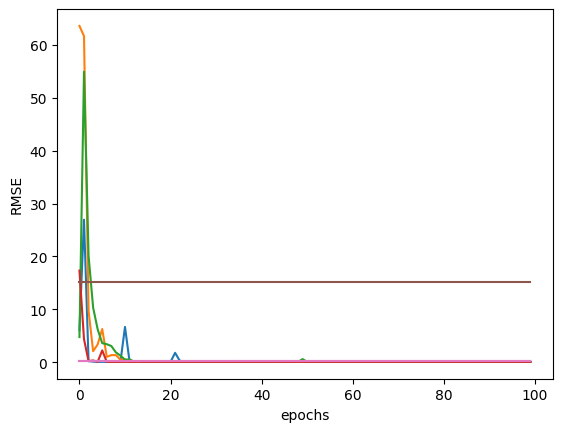

In [ ]:
# activations = ['relu', 'sigmoid', 'softmax', 'softplus', 'softsign', 'tanh', 'selu', 'elu']
activation_groups = [ 
    # ['relu', 'relu', 'sigmoid'],
    # ['relu', 'sigmoid', 'sigmoid'],
    # ['relu', 'softmax', 'sigmoid'],
    # ['relu', 'softplus', 'sigmoid'],
    # ['relu', 'softsign', 'sigmoid'],
    # ['relu', 'tanh', 'sigmoid'],
    # ['relu', 'softmax', 'softplus', 'softsign', 'selu', 'elu', 'sigmoid'],
    # ['relu', 'softplus', 'softsign', 'selu', 'elu', 'sigmoid'],
    # ['relu', 'softsign', 'selu', 'elu', 'sigmoid'],
    ['relu', 'selu', 'elu', 'sigmoid'],
    ['relu', 'selu', 'sigmoid'],
    ['relu', 'elu', 'sigmoid'],
    ['relu', 'elu', 'elu', 'sigmoid'],
    ['elu', 'elu', 'elu', 'relu'],
    ['elu', 'elu', 'elu', 'selu'],
    ['elu', 'elu', 'elu', 'elu'],
    ]
losses = ['poisson']
# losses = ['binary_crossentropy', 'sparse_categorical_crossentropy', 'poisson', 'kl_divergence']
# losses = ['binary_crossentropy', 'kl_divergence']
# optimizers = ['adadelta', 'adagrad', 'adam', 'adamax', 'ftrl', 'nadam', 'rmsprop', 'sgd']
# optimizers = ['adam']
optimizers = ['adam']
units = [200]
for unit in units:
    best_model, best_activation, best_score, best_optimizer = calibrate_model(activation_groups, 100, 100, optimizers, losses, unit)

In [2]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


: 